# Streaming data 

# Part 1 - dealing with JSON

Here, we'll take a look at a publically available data stream, made available by New York's bike sharing company Citi Bike (https://www.citibikenyc.com/system-data), and see what it takes to process the data into something we can work with. 

In this case, we're told the data follows the GBFS standard (https://github.com/NABSA/gbfs/blob/master/gbfs.md), which is based on JSON. To read JSON, we use the `json` library.

In [23]:
import json

Here's a quick example of using the json library to read a JSON string

In [24]:
json_string = '{"one" : "The number 1", "two" : 2, "three" : true}'
j = json.loads(json_string)
print(j['two'])
print(j['three'])
print(type(j)) #print(j['two'])
j

2
True
<class 'dict'>


{'one': 'The number 1', 'two': 2, 'three': True}

## The data

If you go to the 'data feed' linked from the Citi Bike website (http://gbfs.citibikenyc.com/gbfs/gbfs.json) you'll see some json, rendered as text by your browser:

{"last_updated":1526323312,"ttl":10,"data":{"en":{"feeds".......

Checking out the docs (https://github.com/NABSA/gbfs/blob/master/gbfs.md), we see that this is a list of files. Of interest to us is the stations file. We want to observe how many bikes are available at different stations over time. Here's the json: http://www.citibikenyc.com/stations/json

We need to process this a bit. Here, we'll use the urllib linrary to get the json, and then call json.loads() to convert into a dictionary.

In [25]:
import urllib.request

json_string = urllib.request.urlopen('http://www.citibikenyc.com/stations/json').read()
stations = json.loads(json_string)

HTTPError: HTTP Error 503: Service Unavailable

In [ ]:
# Uncomment the following line to see what we get. Hard to tell what it looks like!
# print(stations)
stations.keys()

Take a look at stations and see if you can figure out what's going on. stations.keys() shows that this is a dictionary with two keys: executionTime and stationBeanList. stationBeanList is what we're interested in. A list of dictionaries (which were JSON objects), each representing a station. Here's the first one:

In [ ]:
stations['stationBeanList'][0]

Let's throw this data into a dataframe so we can take a better look at it:

In [ ]:
import pandas as pd
df = pd.DataFrame(stations['stationBeanList'])
df.head()

There we go! How many bikes are available on average?

In [4]:
# Get the average value of the 'availableBikes column
df['availableBikes'].mean()

NameError: name 'df' is not defined

We can repeat the steps to pull the latest available data from the URL (it updates every minute) and see what has changed. Remember, it might be night time in New York, in which case this might be a very boring exercise...

In [5]:
stations = json.loads(urllib.request.urlopen('http://www.citibikenyc.com/stations/json').read()) # Get new data

HTTPError: HTTP Error 503: Service Unavailable

In [ ]:
df = df.append(pd.DataFrame(stations['stationBeanList'])) # Add the data to our existing dataframe

In [11]:
df.loc[df['stAddress1'] == 'W 52 St & 11 Ave'] # Look at one particular station

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,27,28,,72,,2020-05-30 06:45:14 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,55
0,,27,28,,72,,2020-05-30 06:45:14 AM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,55


Now we have two records for each station. 

This is a very slow data stream, and we have to actively go and fetch the data each time. However, you can already see some hypothetical use cases. For example, can you write code to display a list of the emptiest stations, updated every minute? Or print a warning if any station has less than 3 bikes? What about making a plot showing the number of bikes at a given station over time?

If you want to play around with this for practice, try to implement one of the ideas above.

To see an example of how someone else processed this data, check out https://gist.github.com/matmoody/531456524169716929947f39fb043793

# Section 2 - Simulated Streaming Workflow

Here, we'll write code to simulate a common streaming data scenarion - processing information as it arrives. We simulate a stream of data arriving with a for loop. Each time the loop runs, we create a new, imaginary piece of data, which is then processed. We also create some variables outside of the loop - these are state variables to keep track of things like the average or the total number of records received. The last ten records are kept in an array - our moving window.

In [26]:
import pandas as pd
import numpy as np
import math, random

window = [] # The moving window
average_val = 0
window_sd = 0
window_av = 0
n_records = 0
db = pd.DataFrame(columns=['Time', 'Value', 'Average_val', 'sd'])

# def process(record):

for i in range(10):
    # Here is our simulated data: a single value, and a 'time of arrival' (here just i)
    fakeval = math.sin(2*math.pi*i/70) +4 + random.random()
    arrival_time = i
    
    # And here is where we process it
    n_records += 1 # Update the counter
    average_val = average_val*0.75 + fakeval*0.25 # Update the average (exponantial averaging)
    window.append(fakeval) # Add the record to our moving window
    if len(window)>10: # Keep the window size from growing beyond 10:
        del(window[0]) # If the window is >10 items, delete the oldest
    window_sd = np.std(window) # Calculate the standard deviation of the ten items in the window
    window_av = np.mean(window) # Calculate the mean of the last ten readings
    
    # And add the simulated reading and calculated values to a database (or in this case just a pandas DataFrame)
    db = pd.concat([db, pd.DataFrame([{'Time': i, 'Value':fakeval, 'Average_val':average_val, 'sd':window_sd, 'av':window_av}])], ignore_index= True, sort=True)
    # At this stage, we could trigger events if, for example, the average of the last ten readings was too high, or the reading anomalous...

# we've processed 100 incoming records and stored the results. Each row of the dataframe contains the values we'd show at a given time
db.head(100) # The first few rows


,Average_val,Time,Value,av,sd
0,1.132232,0,4.528928,4.528928,0.000000
1,2.064675,1,4.862005,4.695467,0.166539
2,2.720716,2,4.688836,4.693257,0.136014
3,3.186246,3,4.582836,4.665651,0.127126
4,3.679673,4,5.159956,4.764512,0.228085
5,3.995531,5,4.943103,4.794277,0.218591
6,4.335120,6,5.353890,4.874222,0.281608
7,4.459832,7,4.833969,4.869190,0.263756
8,4.545000,8,4.800504,4.861559,0.249607
9,4.776922,9,5.472686,4.922671,0.299476


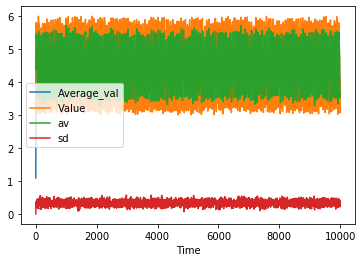

In [16]:
# Plotting the results, including the window average and sd
%matplotlib inline
db.plot(x='Time')

This example shows a lot of things at once. Use the following template to do the following:
- As records 'arrive', print out the Value and the average to date (without storing all records)
- Create a sliding window of size 3. As records arrive, print out the value and the mean of the sliding window
- As records arrive, print an alert when the value is above 5.1. 
- As records arrive, print an alert when the vlaue has been above 4.8 for three consecutive readings



In [ ]:
# Create any variables you'll need here

for i in range(100):
    # Here is our simulated data: a single value, and a 'time of arrival' (here just i)
    fakeval = math.sin(2*math.pi*i/70) +4 + random.random()
    arrival_time = i
    
    # Your code
    #print(i)